## 4) Parametric Methods

Unlike semi-parametric methods that leave the baseline hazard unspecified, parametric methods make assumptions about the shape of the hazard. Therefore they are fit by using the full likelihood function. 

$$ll_{i}=d_{i}log(h(t_{i}))-H(t_{i})$$

where $ll_{i}$ is the contribution of unit $i$ to the likelihood function, $d_{i}$ is the censoring parameter that equals 1 if unit $i$ experienced the event and equals 0 if the unit was censored, $h(t_{i})$ is the hazard function for unit $i$ which experienced the event or was censored at time $t_{i}$ and $H(t_{i})$ is the cumulative hazard function for unit $i$. 

We will first model the survival for the entire group without using covariates. We will try Exponential, Weibull, Gompertz, Loglogistic, Lognormal and Generalized Gamma distributions. Before fitting the models, we can visually inspect plots of transformed empirical survival curves.

### Exponential Survival Model

Exponential distribution assumes a constant hazard rate. Exponential survival distribution is parameterized by $$S(t) = e^{-rt}$$ where $r$ is the hazard rate and $t$ is the time to event. The negative of the logarithm of this function is linear $-ln(S(t)) = rt$ with respect to time. Plotting the negative log of the empirical survival curve against time should give a linear plot. We include a linear fit between negative log of survival times for easier comparison. 

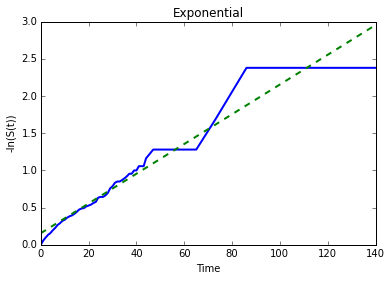

In [132]:
kmf.fit(timevar,event_observed = eventvar,label = "All groups")
plt.figure()
plt.plot(kmf.survival_function_.index.values,-np.log(kmf.survival_function_['All groups']),linewidth = 2.0)
plt.ylabel('-ln(S(t))')
plt.xlabel('Time')
plt.title('Exponential')
y = -np.log(kmf.survival_function_['All groups'])
X = np.asarray(kmf.survival_function_.index.values)
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

The plot suggests that Exponential distribution is not a very good fit for the data, as there are substantial deviations from the straight line after around Time = 30. We now define the loglikelihood function for the exponential distribution and fit the model. We can use the GeneriLikelihoodModel from statsmodels package to specify the likelihood functions.

The loglikelihood function for the Exponential survival model is:

$$ll_{i}=d_{i} log(\mu) - \mu t$$

where $ll_{i}$ is the loglikelihood function for individual $i$, $d_{i}$ is the censoring variable that equals to 1 if unit $i$ experienced the event and to 0 if the unit was censored.

In [133]:
#Define the likelihood function.
#Although we are not using any covariates at this time, we use a vector of
#ones as the 'X' argument for the Generallikelihood function
def _ll_exponential(y,X,scale):
    ll = eventvar * np.log(scale) - (scale * y)
    return ll 
#The Exponential class uses the _ll_exponential function to iteratively update the 
#parameter values to maximiez the likelihood function
class Exponential(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(Exponential, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        ll = _ll_exponential(self.endog,self.exog,params)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if start_params == None:
            start_params = start_params_var 
        return super(Exponential, self).fit(start_params = start_params,maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.711635
         Iterations: 17
         Function evaluations: 34
                             Exponential Results                              
Dep. Variable:                   Time   Log-Likelihood:                -1109.1
Model:                    Exponential   AIC:                             2220.
Method:            Maximum Likelihood   BIC:                             2225.
Date:                Sat, 14 Nov 2015                                         
Time:                        18:58:26                                         
No. Observations:                 648                                         
Df Residuals:                     647                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------

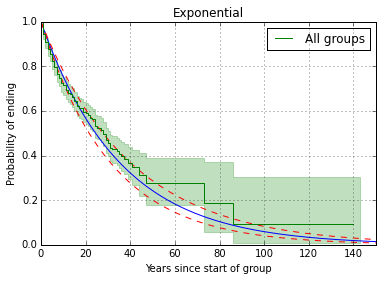

In [134]:
kmf.fit(timevar,event_observed = eventvar,label = "All groups")
#Exponential
#Specify starting values for the parameters
start_params_var = np.repeat(0.5,1)
exp_data = np.repeat(1,len(timevar))
mod_exponential = Exponential(timevar,exp_data)
res_exp = mod_exponential.fit()
print(res_exp.summary())

#Plot the exponential prediction against the empirical survival curve
#Prediction intervals are calculated by complementary log - log transform
#of the survival prediction. The variance of the log - log of the survival
#term is approximated by the delta method, explained on the state website:
#www.stata.com/support/faqs/statistics/delta-method
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_exponential.predict_survival_exponential(res_exp.params, t))
plt.plot(t,mod_exponential.predict_survival_exponential_cis(res_exp.params, res_exp.bse, t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_exponential.predict_survival_exponential_cis(res_exp.params, res_exp.bse, t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Exponential')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('Exponential.png',dpi = 300)

### Weibull Survival Model

Weibull survival function is parameterized as: $$ S(t) = e^{-rt^{\gamma}}$$

The $\gamma$ parameter indicates whether the hazard is increasing ($\gamma$ > 1) or decreasing ($\gamma$ < 1). Note that when $\gamma$ parameter equals to 1,we have an exponential distribution; the hazard is constant. 

The log negative log transformation of the Weibull survival is linear with respect to log time; $\gamma log(r) + \gamma log(t)$ vs. $log(t)$. Therefore, log-log transformation of the empirical survival data against log of time should give a linear plot. Again, we fit a linear function for easier assessment.

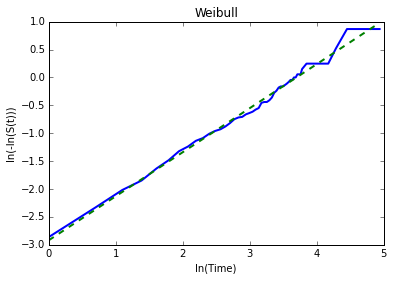

In [135]:
plt.figure()
plt.plot(np.log(kmf.survival_function_.index.values),np.log(-np.log(kmf.survival_function_['All groups'])),linewidth = 2.0)
plt.ylabel('ln(-ln(S(t)))')
plt.xlabel('ln(Time)')
plt.title('Weibull')
y = np.log(-np.log(kmf.survival_function_['All groups'].iloc[1:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

The plot suggests that the Weibull distribution is a better fit, as it closely follows the linear fit, except towards the end of the curve. We now fit the Weibull model to data. 


The loglikelihood function for the Weibull survival model is:
    
$$ll_{i}=d_{i} log(\mu\gamma t^{\gamma-1}) - \mu t^{\gamma}$$

In [136]:
def _ll_weibull(y,X,scale,gamma):
    ll = eventvar * np.log(scale * gamma * np.power(y, (gamma - 1))) - (scale * np.power(y,gamma))
    return ll

class Weibull(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(Weibull, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        scale = params[0]
        gamma = params[1]
        ll = _ll_weibull(self.endog,self.exog,scale,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(Weibull, self).fit(start_params = start_params, maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.708281
         Iterations: 48
         Function evaluations: 91
                               Weibull Results                                
Dep. Variable:                   Time   Log-Likelihood:                -1107.0
Model:                        Weibull   AIC:                             2216.
Method:            Maximum Likelihood   BIC:                             2220.
Date:                Sat, 14 Nov 2015                                         
Time:                        18:58:27                                         
No. Observations:                 648                                         
Df Residuals:                     647                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------

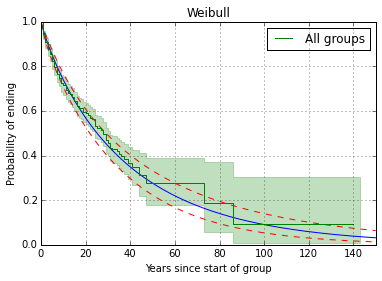

In [137]:
#Weibull
start_params_var = np.repeat(0.5,2)
weibull_data = np.repeat(1,len(timevar))
mod_weibull = Weibull(timevar,weibull_data)
res_wei = mod_weibull.fit()
print(res_wei.summary())

#Plot the weibull prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_weibull.predict_survival_weibull(res_wei.params, t))
plt.plot(t,mod_weibull.predict_survival_weibull_cis(res_wei.params, res_wei.cov_params(), t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_weibull.predict_survival_weibull_cis(res_wei.params, res_wei.cov_params(), t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Weibull')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('Weibull.png',dpi = 300)

### Gompertz Survival Model

Gompertz survival distribution has two parameters, a scale parameter ($\lambda$) and a shape parameter ($\gamma$): $$ S(t)=e^{-\frac{( e^{\lambda} )\ (\ {e^{\gamma t} - 1})}{\gamma}} $$

The log of hazard is linear in gompertz distribution. The integral of the log hazard is linear with respect to time. The hazard of the gompertz survival is $$h(t)=e^{\lambda+\gamma t} $$

We can calculate the hazard at time $t$ from the empirical survival curve by subtracting the negative of the log of the survival probability at time $t_1$ ($-log(S(t_1)$) from the negative log of the survival probability at time $t_2$ ($-log(S(t_2)$)

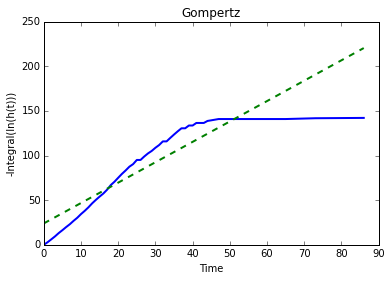

In [138]:
plt.figure()
t_1 = kmf.survival_function_.iloc[0:len(kmf.survival_function_) - 1]
t_2 = kmf.survival_function_.iloc[1:len(kmf.survival_function_)]
gompertz_hazard = []
gompertz_hazard.append(0)
for index in range(len(t_1)):
    #Because we are summing the log of the hazard, check if the 
    #hazard is zero between t_2 and t_1. 
    if (-np.log(t_2.iloc[index,0])+np.log(t_1.iloc[index,0])) > 0:
        gompertz_hazard.append(gompertz_hazard[index] - np.log(-np.log(t_2.iloc[index,0])+np.log(t_1.iloc[index,0])))
    else:
    #If it is, append the latest value of the cumulative hazard at time t_2
        gompertz_hazard.append(gompertz_hazard[index])
plt.plot(t_1.index.values,gompertz_hazard[:-1],linewidth = 2.0)
plt.title('Gompertz')
plt.ylabel('-Integral(ln(h(t)))')
plt.xlabel('Time')
y = gompertz_hazard[:-1]
X = t_1.index.values
X = st.add_constant(X,prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,0],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

Gompertz distribution does not seem to be a good fit to data as it deviates from the line considerably.

The loglikelihood function for the Gompertz survival model is:

$$ll_{i}=d_{i} (\mu+\gamma t) - e^{\mu}(e^{\gamma t}-1)\gamma^{-1}$$

In [139]:
def _ll_gompertz(y,X,scale,gamma):
    ll = eventvar * (scale + gamma * y) - ((np.exp(scale) * (np.exp(gamma * y) - 1)) / gamma)    
    return ll

class Gompertz(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(Gompertz, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        scale = params[0]
        gamma = params[1]
        ll = _ll_gompertz(self.endog,self.exog,scale,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(Gompertz, self).fit(start_params = start_params, maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.705453
         Iterations: 86
         Function evaluations: 166
                               Gompertz Results                               
Dep. Variable:                   Time   Log-Likelihood:                -1105.1
Model:                       Gompertz   AIC:                             2212.
Method:            Maximum Likelihood   BIC:                             2217.
Date:                Sat, 14 Nov 2015                                         
Time:                        18:58:28                                         
No. Observations:                 648                                         
Df Residuals:                     647                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------

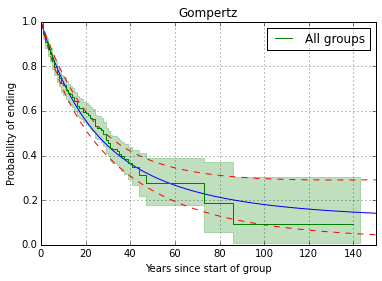

In [140]:
#Gompertz
start_params_var = [0,0]
gompertz_data = np.repeat(1,len(timevar))
mod_gompertz = Gompertz(timevar,gompertz_data)
res_gomp = mod_gompertz.fit()
print(res_gomp.summary())

#Plot the gompertz prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_gompertz.predict_survival_gompertz(res_gomp.params, t))
plt.plot(t,mod_gompertz.predict_survival_gompertz_cis(res_gomp.params, res_gomp.cov_params(), t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_gompertz.predict_survival_gompertz_cis(res_gomp.params, res_gomp.cov_params(), t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Gompertz')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('Gompertz.png',dpi = 300)

### Loglogistic Survival Model

Loglogistic survival distribution is parameterized as $$S(t) = \frac{1}{{1+\lambda t^{\gamma}}}$$

The logarithm of the survival function divided by the cumulative distribution function (log odds of survival) is linear with respect to log of time: $$-log(\frac{S(t)}{1-S(t)}) = \gamma ln(\lambda) + \gamma ln(t) $$

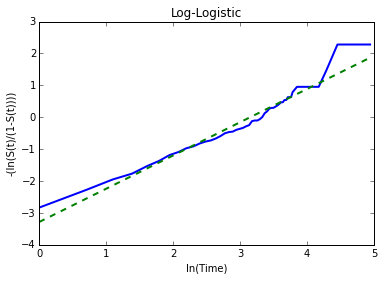

In [141]:
plt.figure()
plt.plot(np.log(kmf.survival_function_.index.values),-np.log(kmf.survival_function_['All groups']/(1-kmf.survival_function_['All groups'])),linewidth = 2.0)
plt.ylabel('Probability of ending')
plt.xlabel('Years')
plt.title('Log-Logistic')
plt.ylabel('-(ln(S(t)/(1-S(t))))')
plt.xlabel('ln(Time)')
y = -np.log(kmf.survival_function_['All groups'].iloc[1:len(kmf.survival_function_)]/(1-kmf.survival_function_['All groups'].iloc[1:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

Overall, the loglogistic survival model does not deviate much from the data. 

Fit loglogistic model to data. The loglikelihood function for the loglogistic survival model is:

$$ll_{i}=d_{i} \frac{log(\mu \gamma t^{\gamma-1})}{1+\mu t^{\gamma}} + log\Bigg(\frac{1}{(1+\mu t^{\gamma})}\Bigg)$$

In [142]:
def _ll_loglogistic(y,X,scale,gamma):
    ll = eventvar * np.log((scale * gamma * np.power(y,gamma - 1))/(1 + scale * np.power(y,gamma))) + np.log(1/(1 + scale * np.power(y,gamma)))    
    return ll

class Loglogistic(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(Loglogistic, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        scale = params[0]
        gamma = params[1]
        ll = _ll_loglogistic(self.endog,self.exog,scale,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(Loglogistic, self).fit(start_params = start_params, maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.703526
         Iterations: 74
         Function evaluations: 140
                             Loglogistic Results                              
Dep. Variable:                   Time   Log-Likelihood:                -1103.9
Model:                    Loglogistic   AIC:                             2210.
Method:            Maximum Likelihood   BIC:                             2214.
Date:                Sat, 14 Nov 2015                                         
Time:                        18:58:28                                         
No. Observations:                 648                                         
Df Residuals:                     647                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------

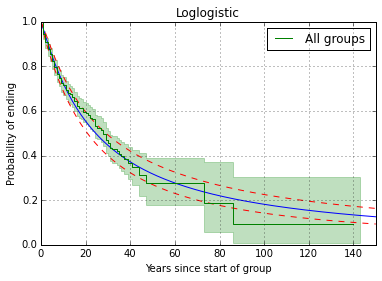

In [143]:
#Log-Logistic
start_params_var = [0,0]
loglogistic_data = np.repeat(1,len(timevar))
mod_loglogistic = Loglogistic(timevar,loglogistic_data)
res_loglog = mod_loglogistic.fit()
print(res_loglog.summary())

#Plot the loglogistic prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_loglogistic.predict_survival_loglogistic(res_loglog.params, t))
plt.plot(t,mod_loglogistic.predict_survival_loglogistic_cis(res_loglog.params, res_loglog.cov_params(), t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_loglogistic.predict_survival_loglogistic_cis(res_loglog.params, res_loglog.cov_params(), t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Loglogistic')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('Loglogistic.png',dpi = 300)

### Lognormal Survival Model

Lognormal survival distribution is parameterized as:

$$ S(t)=1-\Phi((log(t)-\lambda)\gamma)$$ 

where $\Phi$ denotes the cumulative standard distribution

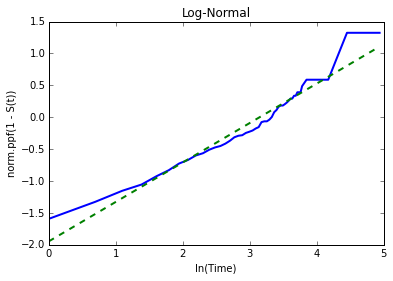

In [144]:
plt.figure()
plt.plot(np.log(kmf.survival_function_.index.values),norm.ppf(1 - kmf.survival_function_['All groups']),linewidth = 2.0)
plt.xlabel('Years')
plt.title('Log-Normal')
plt.ylabel('norm.ppf(1 - S(t))')
plt.xlabel('ln(Time)')
y = norm.ppf(1 - kmf.survival_function_['All groups'].iloc[1:len(kmf.survival_function_)])
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

Fit lognormal model to data.


The loglikelihood function for the loglogistic survival model is:

$$ll_{i}=d_{i}\Bigg(log\Bigg(\frac{\phi((log(t)-\mu)\gamma)}{t \gamma^{-1} (1-\Phi(log(t)-\mu)\gamma)}\Bigg)\Bigg)+log(1-\Phi((log(t)-\mu)\gamma)$$

where $\phi$ is the standard normal probabily density function and $\Phi$ is the standard normal cumulative density function.


In [145]:
def _ll_lognormal(y,X,scale,gamma):
    ll = eventvar * (
    np.log(
    norm.pdf(((np.log(y) - scale) * gamma))/
    (y * (1/gamma) * (1 - norm.cdf((np.log(y) - scale) * gamma))))
    ) + np.log(1 - norm.cdf((np.log(y) - scale) * gamma))
    return ll

class Lognormal(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(Lognormal, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        scale = params[0]
        gamma = params[1]
        ll = _ll_lognormal(self.endog,self.exog,scale,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(Lognormal, self).fit(start_params = start_params, maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.694366
         Iterations: 66
         Function evaluations: 130
                              Lognormal Results                               
Dep. Variable:                   Time   Log-Likelihood:                -1097.9
Model:                      Lognormal   AIC:                             2198.
Method:            Maximum Likelihood   BIC:                             2202.
Date:                Sat, 14 Nov 2015                                         
Time:                        18:58:29                                         
No. Observations:                 648                                         
Df Residuals:                     647                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------

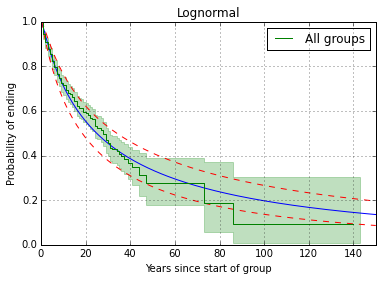

In [146]:
#Log-Normal
start_params_var = [0,0]
lognormal_data = np.repeat(1,len(timevar))
mod_lognormal = Lognormal(timevar,lognormal_data)
res_lognorm = mod_lognormal.fit()
print(res_lognorm.summary())

#Plot the lognormal prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_lognormal.predict_survival_lognormal(res_lognorm.params, t))
plt.plot(t,mod_lognormal.predict_survival_lognormal_cis(res_lognorm.params, res_lognorm.cov_params(), t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_lognormal.predict_survival_lognormal_cis(res_lognorm.params, res_lognorm.cov_params(), t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Lognormal')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('Lognormal.png',dpi = 300)

##Generalized Gamma Survival Model

The density and survival functions for the Generalized gamma are described as:

$$S(t)=\begin{cases}
    1 - I(\gamma,\upsilon),\; \text{if} \;\kappa < 0\\
    1 - \phi(z),\; \text{if} \;\kappa = 0\\
    I(\gamma,\upsilon),\; \text{if} \;\kappa > 0\\
  \end{cases}$$

$$f(t)=\begin{cases}
    \frac{\gamma^{\gamma}}{\sigma t \sqrt{\gamma}\Gamma(\gamma)}e^{z\sqrt{\gamma}-\upsilon},\; \text{if} \;\kappa \neq 0\\
    \frac{1}{\sigma t \sqrt{2\pi}}e^{\frac{-z^{2}}{2}},\; \text{if} \;\kappa = 0\\
  \end{cases}$$

where $\gamma = \frac{1}{|\kappa|^{2}}$ $z=\frac{sign(\kappa)(log(t)-\mu)}{\sigma}$, $\upsilon=\gamma e^{|\kappa|z}$. $I(\gamma,\upsilon)$ is the regularized lower incomplete gamma function:

$$I(\gamma,\upsilon)=\frac{\int_{0}^{\upsilon}e^{-t}t^{\gamma-1}dt}{\Gamma(\gamma)}$$


We can define the log likelihood function separately for different values of $\kappa$ by using the density and survival functions above:

$$ll_{i}=d_{i}log\Bigg(\frac{f_{i}(t)}{S_{i}(t)}\Bigg)+log(S_{i}(t))$$

Generalized Gamma distribution includes Weibull, Exponential and Lognormal distributions as its special cases. More specifically, if $\kappa=1$ it reduces to the Weibull distribution, when $\kappa=1$ and $\sigma=1$ it reduces to the Exponential distribution and if $\kappa=0$, it reduces to the Lognormal distribution. 

In [147]:
def _ll_generalizedgamma(y,X,scale,kappa,sigma):
    gammavalue = np.power(np.abs(kappa),-2)
    zeta = np.sign(kappa) * (np.log(y) - scale) / sigma
    upsilon = gammavalue * np.exp(np.abs(kappa)*zeta)        
    if kappa > 0:
        density = np.power(gammavalue,gammavalue) * np.exp(zeta * np.power(gammavalue,0.5) - upsilon) / (sigma * y * np.power(gammavalue,0.5) * gammafunction(gammavalue))
        survival = 1 - gammainc(gammavalue,upsilon)
        ll = eventvar * np.log(density / survival) + np.log(survival)
    elif kappa == 0: 
        density = np.exp(- np.power(zeta,2) / 2) / (sigma * y * np.power(2 * np.pi,0.5))
        survival = 1 - norm.cdf(zeta)
        ll = eventvar * np.log(density / survival) + np.log(survival)
    elif kappa < 0:
        density = np.power(gammavalue,gammavalue) * np.exp(zeta * np.power(gammavalue,0.5) - upsilon) / (sigma * y * np.power(gammavalue,0.5) * gammafunction(gammavalue))
        survival = gammainc(gammavalue,upsilon)
        ll = eventvar * np.log(density / survival) + np.log(survival)
    return ll
    
class Generalizedgamma(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(Generalizedgamma, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        scale = params[0]
        kappa = params[1]
        sigma = params[2]
        ll = _ll_generalizedgamma(self.endog,self.exog,scale,kappa,sigma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('kappa')
            self.exog_names.append('sigma')
        if start_params == None:
            start_params = start_params_var 
        return super(Generalizedgamma, self).fit(start_params = start_params, method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)


Optimization terminated successfully.
         Current function value: 1.693292
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 22
         Hessian evaluations: 11
                           Generalizedgamma Results                           
Dep. Variable:                   Time   Log-Likelihood:                -1097.3
Model:               Generalizedgamma   AIC:                             2197.
Method:            Maximum Likelihood   BIC:                             2201.
Date:                Sat, 14 Nov 2015                                         
Time:                        18:58:30                                         
No. Observations:                 648                                         
Df Residuals:                     647                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----

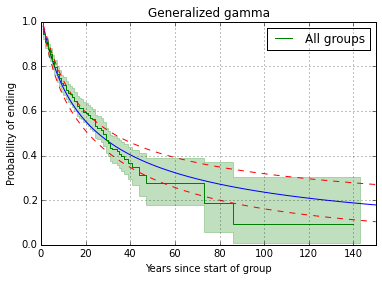

In [148]:
#Generalized gamma
start_params_var = [1,1,1]
generalizedgamma_data = np.repeat(1,len(timevar))
mod_generalizedgamma = Generalizedgamma(timevar,generalizedgamma_data)
res_generalizedgamma = mod_generalizedgamma.fit()
print(res_generalizedgamma.summary())


#Plot the generalized gamma prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(1,150,151)
plt.plot(t,mod_generalizedgamma.predict_survival_generalizedgamma(res_generalizedgamma.params, t))
plt.plot(t,mod_generalizedgamma.predict_survival_generalizedgamma_cis(res_generalizedgamma.params, res_generalizedgamma.cov_params(), t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_generalizedgamma.predict_survival_generalizedgamma_cis(res_generalizedgamma.params, res_generalizedgamma.cov_params(), t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Generalized gamma')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('Generalizedgamma.png',dpi = 300)

Generalized gamma distribution's $\kappa$ parameter is not significant. When $\kappa$ is set to zero, the Generalized Gamma reduces to the Lognormal distribution. 

The AIC and BIC values suggest that the Lognormal survival distribution has the best fit. Although the Generalized Gamma had a slightly lower AIC, the $\kappa$ parameter is not statistically significant, therefore we can conclude that among the distributions we have tried, Lognormal has the best fit to the data.

It is possible to parameterize the scale parameter ($\mu$) in the distributions in terms of variables in the dataset to explore their relationship with the survival outcome. Parameterizations is possible under the proportional hazards or accelerated failure time assumptions. Under the proportional hazards assumption, the coefficients in the model are multiplicative on the hazard, and in an  accelerated failure time coefficients are multiplicative with survival time.

The following table demonstrates how the $\mu$ is parameterized for different distributions under proportional hazards and accelerated failure time assumptions:

|Distribution     |  PH parameterization  |  AFT Parameterization      |
|-----------------|-----------------------|------------------------    |
|Exponential      | $\mu=e^{X^{T}\beta}$  | $\mu=e^{-X^{T}\beta}$      |
|Weibull          | $\mu=e^{X^{T}\beta}$  | $\mu=e^{-X^{T}\beta\gamma}$|
|Gompertz         | $\mu=X^{T}\beta$      |                            |
|Loglogistic      | $\mu=X^{T}\beta$  (Proportional Odds)| $\mu=e^{-X^{T}\beta\gamma}$|
|Lognormal        |                       | $\mu=X^{T}\beta$           |
|Generalized Gamma|                       | $\mu=X^{T}\beta$           |


In [149]:
def _ll_exponentialph(y,X,beta):
    scale = np.exp(np.dot(X,beta))
    ll = eventvar * np.log(scale) - (scale * y)    
    return ll 

class ExponentialPH(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(ExponentialPH, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        ll = _ll_exponentialph(self.endog,self.exog,params)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if start_params == None:
            start_params = start_params_var 
        return super(ExponentialPH, self).fit(start_params = start_params, method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.663364
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 24
         Hessian evaluations: 12
                            ExponentialPH Results                             
Dep. Variable:                   Time   Log-Likelihood:                -1077.9
Model:                  ExponentialPH   AIC:                             2190.
Method:            Maximum Likelihood   BIC:                             2266.
Date:                Sat, 14 Nov 2015                                         
Time:                        18:58:34                                         
No. Observations:                 648                                         
Df Residuals:                     631                                         
Df Model:                          16                                         
                          coef    std err          z      P>|z|      [95.0% Conf. In

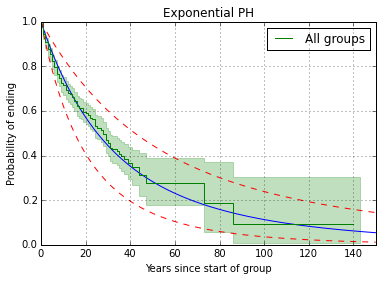

In [150]:
kmf.fit(timevar,event_observed = eventvar,label = "All groups")
#ExponentialPH
start_params_var = np.repeat(0,len(survivaldata.columns))
mod_exponentialph = ExponentialPH(timevar,survivaldata)
res_expPH = mod_exponentialph.fit()
print(res_expPH.summary())

#Plot the exponential PH prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_exponentialph.predict_survival_exponential_ph(res_expPH.params,survivaldata,t))
plt.plot(t,mod_exponentialph.predict_survival_exponential_ph_cis(res_expPH.params,res_expPH.cov_params(),survivaldata,t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_exponentialph.predict_survival_exponential_ph_cis(res_expPH.params,res_expPH.cov_params(),survivaldata,t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Exponential PH')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('ExponentialPH.png',dpi = 300)

In [151]:
def _ll_weibullph(y,X,beta,gamma):
    scale = np.exp(np.dot(X,beta))
    ll = eventvar * np.log(scale * gamma * np.power(y, (gamma - 1))) - (scale * np.power(y,gamma))
    return ll 
   
class WeibullPH(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(WeibullPH, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        gamma = params[-1]
        beta = params[:-1]
        ll = _ll_weibullph(self.endog,self.exog,beta,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(WeibullPH, self).fit(start_params = start_params,method = 'basinhopping',maxiter = maxiter, maxfun = maxfun,**kwds)

basinhopping step 0: f 1.66162
basinhopping step 1: f 1.66162 trial_f 2.96244 accepted 0  lowest_f 1.66162
basinhopping step 2: f 2.11146 trial_f 2.11146 accepted 1  lowest_f 1.66162
basinhopping step 3: f 2.11146 trial_f 2.88275 accepted 0  lowest_f 1.66162
basinhopping step 4: f 1.66162 trial_f 1.66162 accepted 1  lowest_f 1.66162
basinhopping step 5: f 1.66162 trial_f 1.66162 accepted 1  lowest_f 1.66162
basinhopping step 6: f 1.66162 trial_f 1.66162 accepted 1  lowest_f 1.66162
found new global minimum on step 6 with function value 1.66162
basinhopping step 7: f 1.66162 trial_f 1.66162 accepted 1  lowest_f 1.66162
basinhopping step 8: f 1.66162 trial_f 1.82486 accepted 0  lowest_f 1.66162
basinhopping step 9: f 1.66162 trial_f 1.66162 accepted 1  lowest_f 1.66162
basinhopping step 10: f 1.66162 trial_f 1.90357 accepted 0  lowest_f 1.66162
basinhopping step 11: f 1.8615 trial_f 1.8615 accepted 1  lowest_f 1.66162
basinhopping step 12: f 1.8615 trial_f 4.0902 accepted 0  lowest_f 1.6

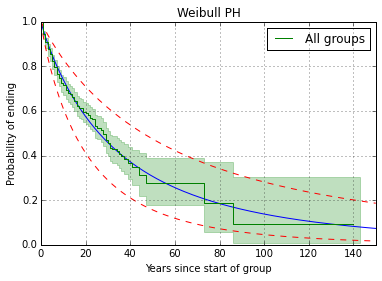

In [152]:
#WeibullPH
#Set the initia gamma value to 1
start_params_var = np.repeat(1,len(survivaldata.columns) + 1)
mod_weibullph = WeibullPH(timevar,survivaldata)
res_weiPH = mod_weibullph.fit()
print(res_weiPH.summary())

#Plot the weibull PH prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_weibullph.predict_survival_weibull_ph(res_weiPH.params,survivaldata,t))
plt.plot(t,mod_weibullph.predict_survival_weibull_ph_cis(res_weiPH.params,res_weiPH.cov_params(),survivaldata,t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_weibullph.predict_survival_weibull_ph_cis(res_weiPH.params,res_weiPH.cov_params(),survivaldata,t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Weibull PH')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('WeibullPH.png',dpi = 300)

In [153]:
def _ll_gompertzph(y,X,beta,gamma):
    scale = np.dot(X,beta)
    ll = eventvar * (scale + gamma * y) - ((np.exp(scale) * (np.exp(gamma * y) - 1)) / gamma)    
    return ll
    
class GompertzPH(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(GompertzPH, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        gamma = params[-1]
        beta = params[:-1]
        ll = _ll_gompertzph(self.endog,self.exog,beta,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(GompertzPH, self).fit(start_params = start_params,method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.659321
         Iterations: 156
         Function evaluations: 160
         Gradient evaluations: 315
         Hessian evaluations: 156
                              GompertzPH Results                              
Dep. Variable:                   Time   Log-Likelihood:                -1075.2
Model:                     GompertzPH   AIC:                             2184.
Method:            Maximum Likelihood   BIC:                             2261.
Date:                Sat, 14 Nov 2015                                         
Time:                        19:01:39                                         
No. Observations:                 648                                         
Df Residuals:                     631                                         
Df Model:                          16                                         
                          coef    std err          z      P>|z|      [95.0% Conf

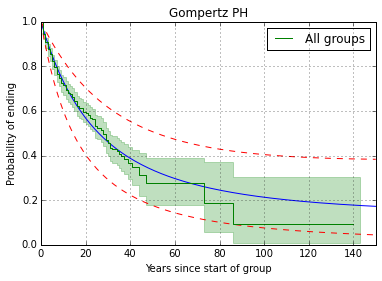

In [154]:
#GompertzPH
start_params_var = np.repeat(0,len(survivaldata.columns))
start_params_var = np.append(start_params_var,1)
mod_gompertzph = GompertzPH(timevar,survivaldata)
res_gompPH = mod_gompertzph.fit()
print(res_gompPH.summary())

#Plot the Gompertz PH prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_gompertzph.predict_survival_gompertz_ph(res_gompPH.params,survivaldata,t))
plt.plot(t,mod_gompertzph.predict_survival_gompertz_ph_cis(res_gompPH.params,res_gompPH.cov_params(),survivaldata,t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_gompertzph.predict_survival_gompertz_ph_cis(res_gompPH.params,res_gompPH.cov_params(),survivaldata,t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Gompertz PH')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('GompertzPH.png',dpi = 300)

In [155]:
def _ll_loglogisticpo(y,X,beta,gamma):
    scale = np.exp(np.dot(X,beta))
    ll = eventvar * np.log((scale * gamma * np.power(y,gamma - 1))/(1 + scale * np.power(y,gamma))) + np.log(1/(1 + scale * np.power(y,gamma)))    
    return ll

class LoglogisticPO(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(LoglogisticPO, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        gamma = params[-1]
        beta = params[:-1]
        ll = _ll_loglogisticpo(self.endog,self.exog,beta,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(LoglogisticPO, self).fit(start_params = start_params, method = 'powell',maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.650185
         Iterations: 22
         Function evaluations: 4168
                            LoglogisticPO Results                             
Dep. Variable:                   Time   Log-Likelihood:                -1069.3
Model:                  LoglogisticPO   AIC:                             2173.
Method:            Maximum Likelihood   BIC:                             2249.
Date:                Sat, 14 Nov 2015                                         
Time:                        19:02:12                                         
No. Observations:                 648                                         
Df Residuals:                     631                                         
Df Model:                          16                                         
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------

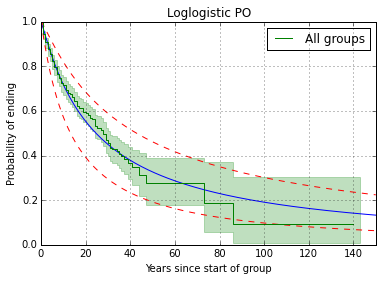

In [156]:
#LoglogisticPO
#Set the initial gamma value to 1
start_params_var = np.repeat(1,len(survivaldata.columns) + 1)
mod_loglogisticpo = LoglogisticPO(timevar,survivaldata)
res_loglogPO = mod_loglogisticpo.fit()
print(res_loglogPO.summary())

#Plot the loglogistic PO prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_loglogisticpo.predict_survival_loglogistic_po(res_loglogPO.params,survivaldata,t))
plt.plot(t,mod_loglogisticpo.predict_survival_loglogistic_po_cis(res_loglogPO.params,res_loglogPO.cov_params(),survivaldata,t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_loglogisticpo.predict_survival_loglogistic_po_cis(res_loglogPO.params,res_loglogPO.cov_params(),survivaldata,t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Loglogistic PO')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('LoglogisticPH.png',dpi = 300)

The next section fits the models with the AFT parameterization. We can check the whether the accelerated failure time assumption that the variables are multiplicative on time by plotting the time variable from different groups against each other. Deviations from a straight line indicate that the AFT assumption does not hold. For this plot, we define a function that takes on two arrays with time information as arguments.

In [157]:
def kmqqplot(array1,array2):
    t1 = []
    t2 = []
    foundt1 = False
    foundt2 = False
    current1index = 0
    current2index = 0
    minpercentile = max(float(array1[[0]].min(axis = 0)),float(array2[[0]].min(axis = 0)))
    percentiles = np.linspace(1,minpercentile,11)
    for x in percentiles:
        foundt1 = False
        foundt2 = False
        for y in xrange(current1index,len(array1)):
            if array1.iloc[y,0] <= x and foundt1 == False:            
                current1index = y
                t1.append(array1.index.values[y])
                foundt1 = True
        for g in xrange(current2index,len(array2)):
            if array2.iloc[g,0] <= x and foundt2 == False:
                t2.append(array2.index.values[g])
                current1index = g
                foundt2 = True
    plt.figure()
    minlength = min(len(t1),len(t2))
    plt.scatter(t1[:minlength],t2[:minlength])
    t1_cons = st.add_constant(t1[:minlength],prepend = False)
    linearmodel = st.OLS(t2[:minlength],t1_cons)
    linearmodelresults = linearmodel.fit()
    plt.plot(t1[:minlength],linearmodelresults.fittedvalues,'g')
    plt.xticks(np.arange(0, max(t1[:minlength]) + 5, 4.0))
    plt.yticks(np.arange(0, max(t2[:minlength]) + 5, 4.0))
    plt.xlim(0,max(t1[:minlength]) + 4)
    plt.ylim(0,max(t2[:minlength]) + 4)
    plt.xlabel(array1.columns.values[0])
    plt.ylabel(array2.columns.values[0])

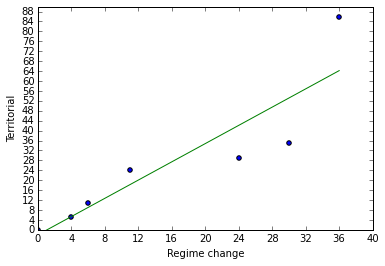

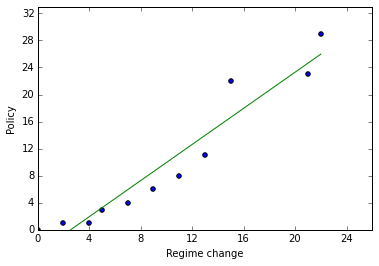

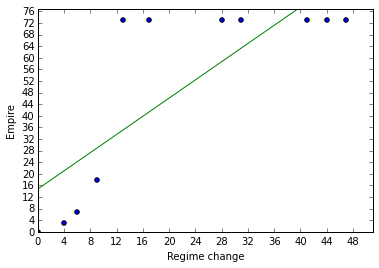

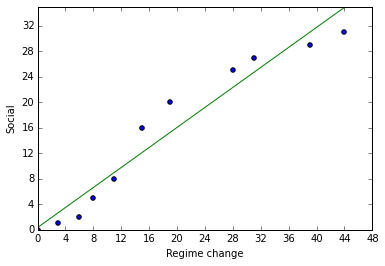

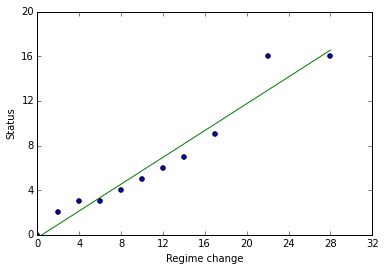

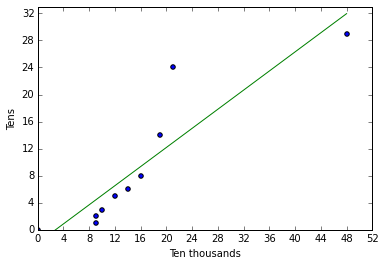

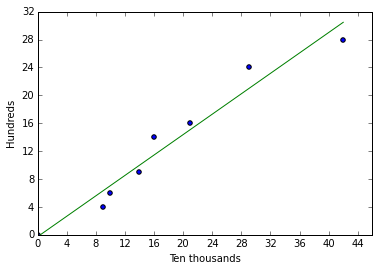

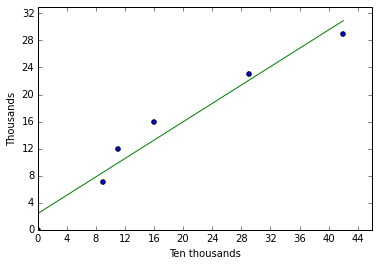

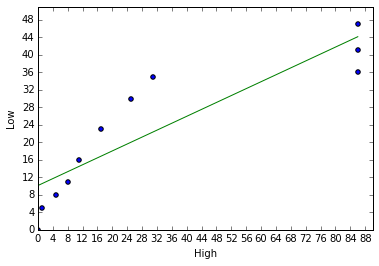

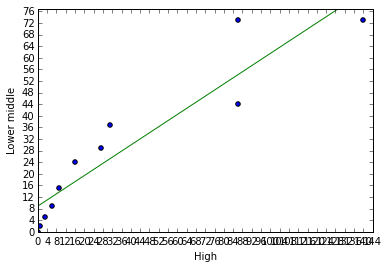

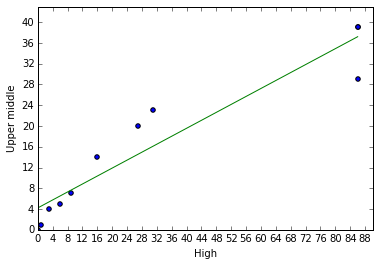

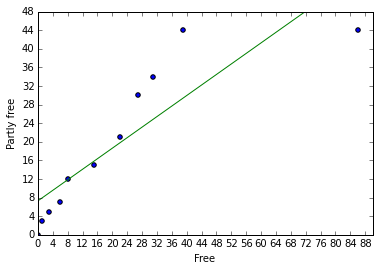

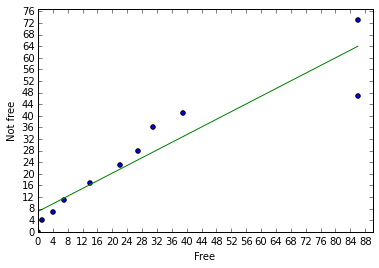

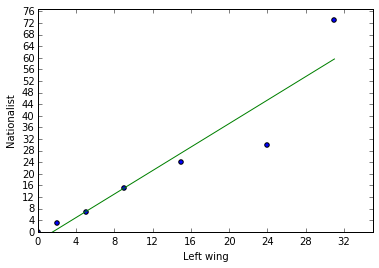

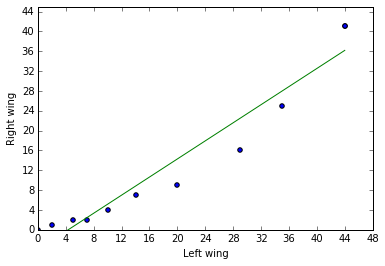

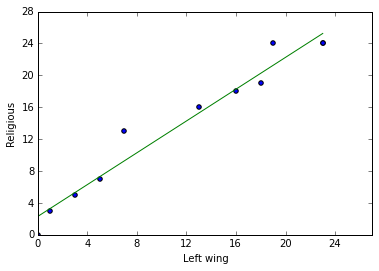

In [158]:
#Fit Kaplan Meier curves for each group, then plot times from different groups against each other
kmf_regime = KaplanMeierFitter()
kmf_regime.fit(timevar[regime],event_observed = eventvar[regime],label = "Regime change")
kmf_territorial = KaplanMeierFitter()
kmf_territorial.fit(timevar[territorial],event_observed = eventvar[territorial],label = "Territorial")
kmf_policy = KaplanMeierFitter()
kmf_policy.fit(timevar[policy],event_observed = eventvar[policy],label = "Policy")
kmf_empire = KaplanMeierFitter()
kmf_empire.fit(timevar[empire],event_observed = eventvar[empire],label = "Empire")
kmf_social = KaplanMeierFitter()
kmf_social.fit(timevar[social],event_observed = eventvar[social],label = "Social")
kmf_status = KaplanMeierFitter()
kmf_status.fit(timevar[status],event_observed = eventvar[status],label = "Status")

kmqqplot(kmf_regime.survival_function_,kmf_territorial.survival_function_)
kmqqplot(kmf_regime.survival_function_,kmf_policy.survival_function_)
kmqqplot(kmf_regime.survival_function_,kmf_empire.survival_function_)
kmqqplot(kmf_regime.survival_function_,kmf_social.survival_function_)
kmqqplot(kmf_regime.survival_function_,kmf_status.survival_function_)

kmf_tenthousands = KaplanMeierFitter()
kmf_tenthousands.fit(timevar[tenthousands],event_observed = eventvar[tenthousands],label = "Ten thousands")
kmf_tens = KaplanMeierFitter()
kmf_tens.fit(timevar[tens],event_observed = eventvar[tens],label = "Tens")
kmf_hundreds = KaplanMeierFitter()
kmf_hundreds.fit(timevar[hundreds],event_observed = eventvar[hundreds],label = "Hundreds")
kmf_thousands = KaplanMeierFitter()
kmf_thousands.fit(timevar[thousands],event_observed = eventvar[thousands],label = "Thousands")

kmqqplot(kmf_tenthousands.survival_function_,kmf_tens.survival_function_)
kmqqplot(kmf_tenthousands.survival_function_,kmf_hundreds.survival_function_)
kmqqplot(kmf_tenthousands.survival_function_,kmf_thousands.survival_function_)

kmf_low = KaplanMeierFitter()
kmf_low.fit(timevar[low],event_observed = eventvar[low],label = "Low")
kmf_lowermiddle = KaplanMeierFitter()
kmf_lowermiddle.fit(timevar[lowermiddle],event_observed = eventvar[lowermiddle],label = "Lower middle")
kmf_uppermiddle = KaplanMeierFitter()
kmf_uppermiddle.fit(timevar[uppermiddle],event_observed = eventvar[uppermiddle],label = "Upper middle")
kmf_high = KaplanMeierFitter()
kmf_high.fit(timevar[high],event_observed = eventvar[high],label = "High")

kmqqplot(kmf_high.survival_function_,kmf_low.survival_function_)
kmqqplot(kmf_high.survival_function_,kmf_lowermiddle.survival_function_)
kmqqplot(kmf_high.survival_function_,kmf_uppermiddle.survival_function_)

kmf_free = KaplanMeierFitter()
kmf_free.fit(timevar[free],event_observed = eventvar[free],label = "Free")
kmf_partlyfree = KaplanMeierFitter()
kmf_partlyfree.fit(timevar[partlyfree],event_observed = eventvar[partlyfree],label = "Partly free")
kmf_notfree = KaplanMeierFitter()
kmf_notfree.fit(timevar[notfree],event_observed = eventvar[notfree],label = "Not free")

kmqqplot(kmf_free.survival_function_,kmf_partlyfree.survival_function_)
kmqqplot(kmf_free.survival_function_,kmf_notfree.survival_function_)

kmf_left_wing = KaplanMeierFitter()
kmf_left_wing.fit(timevar[left_wing],event_observed = eventvar[left_wing],label = "Left wing")
kmf_nationalist = KaplanMeierFitter()
kmf_nationalist.fit(timevar[nationalist],event_observed = eventvar[nationalist],label = "Nationalist")
kmf_right_wing = KaplanMeierFitter()
kmf_right_wing.fit(timevar[right_wing],event_observed = eventvar[right_wing],label = "Right wing")
kmf_religious = KaplanMeierFitter()
kmf_religious.fit(timevar[religious],event_observed = eventvar[religious],label = "Religious")

kmqqplot(kmf_left_wing.survival_function_,kmf_nationalist.survival_function_)
kmqqplot(kmf_left_wing.survival_function_,kmf_right_wing.survival_function_)
kmqqplot(kmf_left_wing.survival_function_,kmf_religious.survival_function_)   

Except for groups that seek to found an empire, there are no major deviations from the AFT assumption.

The next section shows the implementation of the AFT parameterization with different survival models.

In [159]:
def _ll_exponentialaft(y,X,beta):
    scale = np.exp(-np.dot(X,beta))
    ll = eventvar * np.log(scale) - (scale * y)    
    return ll 

class ExponentialAFT(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(ExponentialAFT, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        ll = _ll_exponentialaft(self.endog,self.exog,params)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if start_params == None:
            start_params = start_params_var 
        return super(ExponentialAFT, self).fit(start_params = start_params, method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.663364
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 24
         Hessian evaluations: 12
                            ExponentialAFT Results                            
Dep. Variable:                   Time   Log-Likelihood:                -1077.9
Model:                 ExponentialAFT   AIC:                             2190.
Method:            Maximum Likelihood   BIC:                             2266.
Date:                Sat, 14 Nov 2015                                         
Time:                        19:02:51                                         
No. Observations:                 648                                         
Df Residuals:                     631                                         
Df Model:                          16                                         
                          coef    std err          z      P>|z|      [95.0% Conf. In

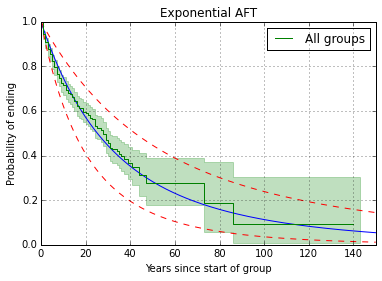

In [160]:
#ExponentialAFT
start_params_var = np.repeat(0,len(survivaldata.columns))
mod_exponentialaft = ExponentialAFT(timevar,survivaldata)
res_expAFT = mod_exponentialaft.fit()
print(res_expAFT.summary())

#Plot the exponential AFT prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_exponentialaft.predict_survival_exponential_aft(res_expAFT.params,survivaldata,t))
plt.plot(t,mod_exponentialaft.predict_survival_exponential_aft_cis(res_expAFT.params,res_expAFT.cov_params(),survivaldata,t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_exponentialaft.predict_survival_exponential_aft_cis(res_expAFT.params,res_expAFT.cov_params(),survivaldata,t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Exponential AFT')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('ExponentialAFT.png',dpi = 300)

In [161]:
def _ll_weibullaft(y,X,beta,gamma):
    scale = np.exp(-1 * np.dot(X,beta) * gamma)
    ll = eventvar * np.log(scale * gamma * np.power(y, (gamma - 1))) - (scale * np.power(y,gamma))
    return ll 
   
class WeibullAFT(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(WeibullAFT, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        gamma = params[-1]
        beta = params[:-1]
        ll = _ll_weibullaft(self.endog,self.exog,beta,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(WeibullAFT, self).fit(start_params = start_params, method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.661621
         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 24
         Hessian evaluations: 11
                              WeibullAFT Results                              
Dep. Variable:                   Time   Log-Likelihood:                -1076.7
Model:                     WeibullAFT   AIC:                             2187.
Method:            Maximum Likelihood   BIC:                             2264.
Date:                Sat, 14 Nov 2015                                         
Time:                        19:03:23                                         
No. Observations:                 648                                         
Df Residuals:                     631                                         
Df Model:                          16                                         
                          coef    std err          z      P>|z|      [95.0% Conf. In

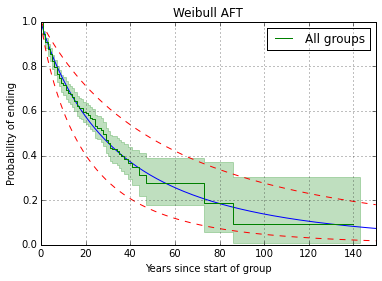

In [162]:
#WeibullAFT
#Set the initial gamma value to 1
start_params_var = np.repeat(1,len(survivaldata.columns) + 1)
mod_weibullaft = WeibullAFT(timevar,survivaldata)
res_weiAFT = mod_weibullaft.fit()
print(res_weiAFT.summary())

#Plot the weibull AFT prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_weibullaft.predict_survival_weibull_aft(res_weiAFT.params,survivaldata,t))
plt.plot(t,mod_weibullaft.predict_survival_weibull_aft_cis(res_weiAFT.params,res_weiAFT.cov_params(),survivaldata,t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_weibullaft.predict_survival_weibull_aft_cis(res_weiAFT.params,res_weiAFT.cov_params(),survivaldata,t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Weibull AFT')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('WeibullAFT.png',dpi = 300)

In [163]:
def _ll_loglogisticaft(y,X,beta,gamma):
    scale = np.exp(- np.dot(X,beta) * gamma)
    ll = eventvar * np.log((scale * gamma * np.power(y,gamma - 1))/(1 + scale * np.power(y,gamma))) + np.log(1/(1 + scale * np.power(y,gamma)))    
    return ll

class LoglogisticAFT(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(LoglogisticAFT, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        gamma = params[-1]
        beta = params[:-1]
        ll = _ll_loglogisticaft(self.endog,self.exog,beta,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(LoglogisticAFT, self).fit(start_params = start_params, method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.650116
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 21
         Hessian evaluations: 10
                            LoglogisticAFT Results                            
Dep. Variable:                   Time   Log-Likelihood:                -1069.3
Model:                 LoglogisticAFT   AIC:                             2173.
Method:            Maximum Likelihood   BIC:                             2249.
Date:                Sat, 14 Nov 2015                                         
Time:                        19:03:58                                         
No. Observations:                 648                                         
Df Residuals:                     631                                         
Df Model:                          16                                         
                          coef    std err          z      P>|z|      [95.0% Conf. In

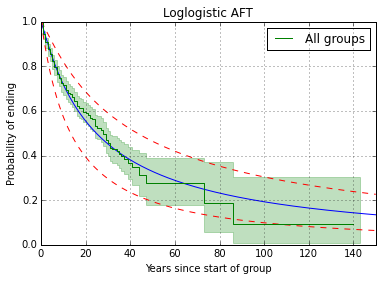

In [164]:
#LoglogisticAFT
#Set the initia gamma value to 1
start_params_var = np.repeat(1,len(survivaldata.columns) + 1)
mod_loglogisticaft = LoglogisticAFT(timevar,survivaldata)
res_loglogAFT = mod_loglogisticaft.fit()
print(res_loglogAFT.summary())

#Plot the loglogistic AFT prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_loglogisticaft.predict_survival_loglogistic_aft(res_loglogAFT.params,survivaldata,t))
plt.plot(t,mod_loglogisticaft.predict_survival_loglogistic_aft_cis(res_loglogAFT.params,res_loglogAFT.cov_params(),survivaldata,t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_loglogisticaft.predict_survival_loglogistic_aft_cis(res_loglogAFT.params,res_loglogAFT.cov_params(),survivaldata,t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Loglogistic AFT')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('LoglogisticAFT.png',dpi = 300)

In [165]:
def _ll_lognormalaft(y,X,beta,gamma):
    scale = np.dot(X,beta)
    ll = eventvar * (
    np.log(
    norm.pdf(((np.log(y) - scale) * gamma))/
    (y * (1/gamma) * (1 - norm.cdf((np.log(y) - scale) * gamma))))
    ) + np.log(1 - norm.cdf((np.log(y) - scale) * gamma))
    return ll

class LognormalAFT(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(LognormalAFT, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        gamma = params[-1]
        beta = params[:-1]
        ll = _ll_lognormalaft(self.endog,self.exog,beta,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(LognormalAFT, self).fit(start_params = start_params,method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.640467
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 25
         Hessian evaluations: 12
                             LognormalAFT Results                             
Dep. Variable:                   Time   Log-Likelihood:                -1063.0
Model:                   LognormalAFT   AIC:                             2160.
Method:            Maximum Likelihood   BIC:                             2236.
Date:                Sat, 14 Nov 2015                                         
Time:                        19:04:37                                         
No. Observations:                 648                                         
Df Residuals:                     631                                         
Df Model:                          16                                         
                          coef    std err          z      P>|z|      [95.0% Conf. In

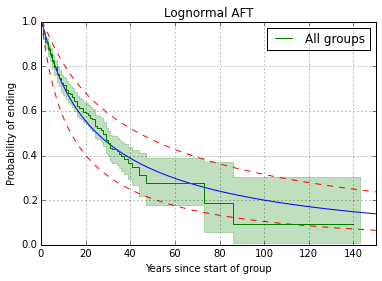

In [166]:
#LognormalAFT
start_params_var = np.repeat(1,len(survivaldata.columns) + 1)
mod_lognormalaft = LognormalAFT(timevar,survivaldata)
res_lognormAFT = mod_lognormalaft.fit()
print(res_lognormAFT.summary())


#Plot the lognormal AFT prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(0,150,151)
plt.plot(t,mod_lognormalaft.predict_survival_lognormal_aft(res_lognormAFT.params,survivaldata,t))
plt.plot(t,mod_lognormalaft.predict_survival_lognormal_aft_cis(res_lognormAFT.params,res_lognormAFT.cov_params(),survivaldata,t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_lognormalaft.predict_survival_lognormal_aft_cis(res_lognormAFT.params,res_lognormAFT.cov_params(),survivaldata,t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Lognormal AFT')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('LognormalAFT.png',dpi = 300)

In [167]:
def _ll_generalizedgammaaft(y,X,beta,kappa,sigma):
    scale = np.dot(X,beta)
    gammavalue = np.power(np.abs(kappa),-2)
    zeta = np.sign(kappa) * (np.log(y) - scale) / sigma
    upsilon = gammavalue * np.exp(np.abs(kappa)*zeta)        
    if kappa > 0:
        density = np.power(gammavalue,gammavalue) * np.exp(zeta * np.power(gammavalue,0.5) - upsilon) / (sigma * y * np.power(gammavalue,0.5) * gammafunction(gammavalue))
        survival = 1 - gammainc(gammavalue,upsilon)
        ll = eventvar * np.log(density / survival) + np.log(survival)
    elif kappa == 0: 
        density = np.exp(- np.power(zeta,2) / 2) / (sigma * y * np.power(2 * np.pi,0.5))
        survival = 1 - norm.cdf(zeta)
        ll = eventvar * np.log(density / survival) + np.log(survival)
    elif kappa < 0:
        density = np.power(gammavalue,gammavalue) * np.exp(zeta * np.power(gammavalue,0.5) - upsilon) / (sigma * y * np.power(gammavalue,0.5) * gammafunction(gammavalue))
        survival = gammainc(gammavalue,upsilon)
        ll = eventvar * np.log(density / survival) + np.log(survival)
    return ll
    
class GeneralizedgammaAFT(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(GeneralizedgammaAFT, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        beta = params[:-2]
        kappa = params[-2]
        sigma = params[-1]
        ll = _ll_generalizedgammaaft(self.endog,self.exog,beta,kappa,sigma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('kappa')
            self.exog_names.append('sigma')
        if start_params == None:
            start_params = start_params_var 
        return super(GeneralizedgammaAFT, self).fit(start_params = start_params, method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

Optimization terminated successfully.
         Current function value: 1.632725
         Iterations: 13
         Function evaluations: 21
         Gradient evaluations: 32
         Hessian evaluations: 13
                          GeneralizedgammaAFT Results                          
Dep. Variable:                    Time   Log-Likelihood:                -1058.0
Model:             GeneralizedgammaAFT   AIC:                             2150.
Method:             Maximum Likelihood   BIC:                             2226.
Date:                 Sat, 14 Nov 2015                                         
Time:                         19:06:12                                         
No. Observations:                  648                                         
Df Residuals:                      631                                         
Df Model:                           16                                         
                          coef    std err          z      P>|z|      [95.0%

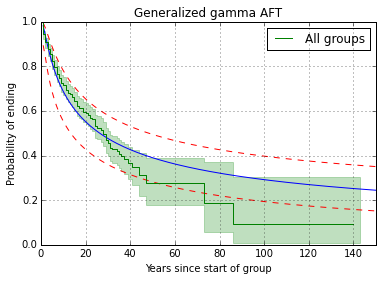

In [168]:
#Generalized gamma AFT
start_params_var = np.repeat(1,len(survivaldata.columns) + 2)
mod_generalizedgammaaft = GeneralizedgammaAFT(timevar,survivaldata)
res_generalizedgammaAFT = mod_generalizedgammaaft.fit()
print(res_generalizedgammaAFT.summary())
#Plot the generalized gamma aft prediction against the empirical survival curve
plt.figure()
ax = plt.subplot(1,1,1)
t = np.linspace(1,150,150)
plt.plot(t,mod_generalizedgammaaft.predict_survival_generalizedgamma_aft(res_generalizedgammaAFT.params, survivaldata, t))
plt.plot(t,mod_generalizedgammaaft.predict_survival_generalizedgamma_aft_cis(res_generalizedgammaAFT.params, res_generalizedgammaAFT.cov_params(), survivaldata, t)[[1]],'r--',linewidth = 1.0)
plt.plot(t,mod_generalizedgammaaft.predict_survival_generalizedgamma_aft_cis(res_generalizedgammaAFT.params, res_generalizedgammaAFT.cov_params(), survivaldata, t)[[2]],'r--',linewidth = 1.0)
kmf.plot(ax = ax)
plt.title('Generalized gamma AFT')
plt.xlabel('Years since start of group')
plt.ylabel('Probability of ending')
plt.savefig('GeneralizedgammaAFT.png',dpi = 300)

Results from the models with AFT and PH assumptions are summarized in the table below. Groups that seek territorial change last longer under the AFT assumption and their hazard of ending at any time is lower under the PH assumptio compared to groups that seek regime change. Religious groups last longer under the AFT assumption and their hazard of ending at any time is lower under the PH assumptio compared to left wing groups. Loglogistic, lognormal and Generalized Gamma AFT models suggest that right wing groups end earlier compared to left wing groups and the loglogistic PO model suggests that the odds of ending are higher for right wing groups compared to left wing groups. None of the PH models found a relationship between the operating peak size of the group and hazard of ending. Loglogistic, lognormal and Generalized gamma AFT models suggest that groups with less than 100 members, end earlier compared to groups whose peak operating size is in the ten thousands. Interestingly, none of the models suggest that the freedom index level and income level of the country against which the terrorist groups are operating is associated with a different survival duration.

#### Results (coefficient, [p-value], $* p<0.05$, $** p<0.01$)
|Variable	|Exponential AFT	|Weibull AFT	|Loglogistic AFT	|Lognormal AFT	|Ggamma AFT	|Exponential PH	|Weibull PH	|Gompertz PH	|Loglogistic PO|
|-------------------	|-------------------	|-------------------	|-------------------	|-------------------	|-------------------	|-------------------	|-------------------	|-------------------	|-------------------|
|Territorial change	| 0.648 [0.004]**	| 0.696 [0.005]**	| 0.756 [0.002]**	| 0.790 [0.001]**	| 0.752 [0.001]**	| -0.646 [0.004]**	| -0.645 [0.004]**	| -0.641 [0.004]**	| -0.849 [0.003]**|
|Policy change	| 0.227 [0.24]	| 0.235 [0.259]	| 0.15 [0.494]	| 0.137 [0.525]	| -0.053 [0.8]	| -0.227 [0.24]	| -0.217 [0.259]	| -0.211 [0.274]	| -0.164 [0.516]|
|Empire	| 0.088 [0.846]	| 0.071 [0.886]	| -0.055 [0.914]	| -0.149 [0.751]	| -0.360 [0.373]	| -0.088 [0.846]	| -0.065 [0.886]	| -0.012 [0.979]	| 0.138 [0.814]|
|Social revolution	| 0.06 [0.803]	| 0.065 [0.8]	| 0.006 [0.983]	| 0.007 [0.978]	| -0.122 [0.642]	| -0.06 [0.803]	| -0.060 [0.8]	| -0.04 [0.866]	| -0.022 [0.945]|
|Status Quo	| 0.189 [0.58]	| 0.206 [0.573]	| 0.176 [0.664]	| 0.241 [0.545]	| 0.25 [0.506]	| -0.188 [0.58]	| -0.191 [0.573]	| -0.220 [0.517]	| -0.191 [0.681]|
|1,000s	| 0.265 [0.392]	| 0.265 [0.427]	| 0.130 [0.714]	| 0.119 [0.756]	| 0.003 [0.993]	| -0.265 [0.392]	| -0.245 [0.428]	| -0.194 [0.529]	| -0.144 [0.725]|
|100s	| -0.349 [0.22]	| -0.351 [0.253]	| -0.495 [0.135]	| -0.506 [0.153]	| -0.704 [0.045]**	| 0.349 [0.22]	| 0.325 [0.253]	| 0.302 [0.287]	| 0.55 [0.152]|
|10s	| -0.38 [0.181]	| -0.361 [0.239]	| -0.651 [0.049]**	| -0.735 [0.035]**	| -1.237 [0.001]**	| 0.38 [0.181]	| 0.334 [0.241]	| 0.297 [0.297]	| 0.765 [0.047]|
|Low income	| -0.136 [0.584]	| -0.120 [0.654]	| -0.052 [0.852]	| -0.044 [0.873]	| -0.034 [0.895]	| 0.136 [0.584]	| 0.111 [0.654]	| 0.077 [0.757]	| 0.04 [0.902]|
|Lower middle income	| 0.033 [0.884]	| 0.047 [0.85]	| 0.053 [0.844]	| 0.025 [0.924]	| -0.045 [0.855]	| -0.033 [0.884]	| -0.043 [0.85]	| -0.054 [0.81]	| -0.096 [0.754]|
|Upper middle income	| -0.242 [0.308]	| -0.243 [0.343]	| -0.197 [0.468]	| -0.196 [0.465]	| -0.023 [0.927]	| 0.242 [0.308]	| 0.225 [0.344]	| 0.209 [0.377]	| 0.208 [0.505]|
|Partly free	| 0.068 [0.728]	| 0.081 [0.701]	| 0.103 [0.645]	| 0.111 [0.619]	| 0.107 [0.605]	| -0.068 [0.728]	| -0.075 [0.701]	| -0.082 [0.673]	| -0.098 [0.704]|
|Free	| 0.152 [0.491]	| 0.169 [0.48]	| 0.215 [0.393]	| 0.169 [0.503]	| 0.077 [0.745]	| -0.152 [0.491]	| -0.156 [0.479]	| -0.162 [0.464]	| -0.248 [0.393]|
|Nationalist	| 0.095 [0.616]	| 0.096 [0.639]	| 0.018 [0.934]	| -0.061 [0.78]	| -0.287 [0.193]	| -0.095 [0.616]	| -0.089 [0.639]	| -0.079 [0.676]	| -0.015 [0.953]|
|Religious	| 1.137 [0]**	| 1.240 [0]**	| 1.171 [0]**	| 1.104 [0]**	| 0.812 [0.001]**	| -1.137 [0]**	| -1.148 [0]**	| -1.153 [0]**	| -1.350 [0]**|
|Right wing	| -0.371 [0.135]	| -0.408 [0.127]	| -0.759 [0.012]*	| -0.719 [0.014]*	| -0.752 [0.01]*	| 0.371 [0.135]	| 0.378 [0.126]	| 0.435 [0.078]	| 0.882 [0.012]*|



The next section describes how the confidence intervals are calculated for the survival predictions.